In [11]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import mat73
from scipy.ndimage import convolve
from scipy.ndimage import map_coordinates
import numba as nb

In [2]:
data1 = mat73.loadmat('/Users/bhoomi/Desktop/CS 736/Assignemnt_2/assignmentMathImagingRecon/data/assignmentMathImagingRecon_chestCT.mat')
chestCT = data1['imageAC']

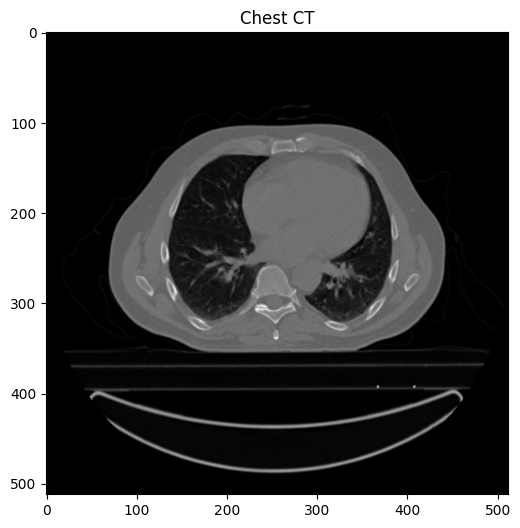

In [3]:
plt.figure(figsize=(6, 6))
plt.imshow(chestCT, cmap='gray')
plt.title("Chest CT")
plt.show()

In [4]:
@nb.njit
def compute_rrmse_jit(A, B):
    N = A.shape[0]
    s_error = 0.0
    normA = 0.0
    for i in range(N):
        for j in range(N):
            diff = A[i, j] - B[i, j]
            s_error += diff * diff
            normA += A[i, j] * A[i, j]
    return np.sqrt(s_error) / np.sqrt(normA)

In [5]:
@nb.njit
def compute_ray_weights_jit(t, theta_rad, N, s):
    """
    Compute the weight matrix W (of shape (N,N)) for a ray defined by
    t (offset) and theta (in radians) using integration step s.
    """
    W = np.zeros((N, N))
    center = (N - 1) / 2.0
    L_max = np.sqrt(center * center + center * center)
    L_range = L_max * np.sqrt(2)
    n_samples = int((2 * L_range) / s) + 1
    for i in range(n_samples):
        l = -L_range + i * s
        x = t * np.cos(theta_rad) - l * np.sin(theta_rad)
        y = t * np.sin(theta_rad) + l * np.cos(theta_rad)
        c = int(np.round(x + center))
        r = int(np.round(center - y))
        if r >= 0 and r < N and c >= 0 and c < N:
            W[r, c] += s
    return W

In [6]:
@nb.njit
def art_update_jit_with_errors(f, chestCT, angles, t_values, lambda_val, s, max_iter, sigma):
    """
    Perform ART updates on image f while tracking RRMSE at the end of each iteration.

    Parameters:
      f         : 2D numpy array (initial estimate; modified in place)
      chestCT   : 2D numpy array (ground-truth image, used for simulating measurements)
      angles    : 1D numpy array of projection angles (in degrees)
      t_values  : 1D numpy array of detector positions
      lambda_val: relaxation parameter (step length)
      s         : integration step size
      max_iter  : number of full iterations over all rays

    Returns:
      f         : the reconstructed image after ART iterations
      errors    : a 1D numpy array of RRMSE values, one per iteration
    """
    N = f.shape[0]
    n_angles = angles.shape[0]
    n_t = t_values.shape[0]
    errors = np.zeros(max_iter)

    for it in range(max_iter):
        # Loop over each projection angle.
        for i in range(n_angles):
            theta_rad = angles[i] * np.pi / 180.0
            # Loop over each detector position.
            for j in range(n_t):
                t_val = t_values[j]
                # Compute the ray weight matrix for current (t, theta)
                W = compute_ray_weights_jit(t_val, theta_rad, N, s)

                # Compute current projection: p = sum(W * f)
                p = 0.0
                norm2 = 0.0
                for r in range(N):
                    for c in range(N):
                        val = W[r, c]
                        p += val * f[r, c]
                        norm2 += val * val

                # Compute the simulated measurement from the ground truth.
                b = 0.0
                for r in range(N):
                    for c in range(N):
                        b += W[r, c] * chestCT[r, c]
                b += sigma * np.random.randn()
                # ART update: if norm2 > 0.
                if norm2 > 0:
                    error_val = b - p
                    factor = lambda_val * error_val / norm2
                    for r in range(N):
                        for c in range(N):
                            f[r, c] += factor * W[r, c]
        # Compute RRMSE after one full iteration.
        errors[it] = compute_rrmse_jit(chestCT, f)
    return f, errors

Starting ART reconstruction with error tracking (Numba accelerated)...


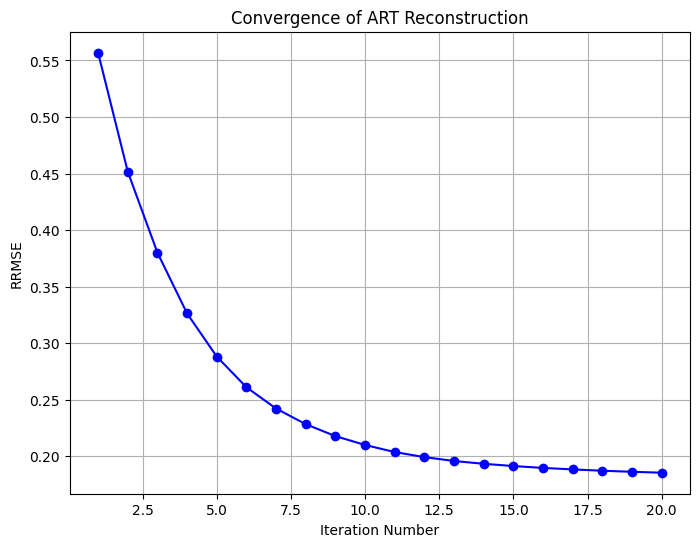

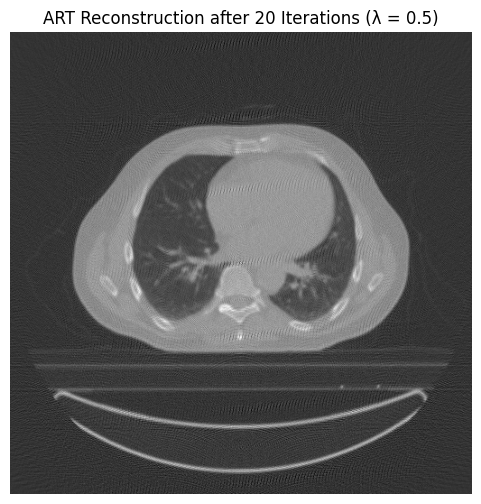

Final RRMSE: 0.18541203218850896


In [7]:
chestCT = chestCT.astype(np.float64)
# if chestCT.shape[0] != 512:
#     chestCT = resize(chestCT, (512, 512), mode='reflect', anti_aliasing=True)
N = 512

# Define acquisition parameters.
angles = np.arange(0, 180, 1)  # 180 angles: 0, 1, ... 179 degrees.
P = 512  # number of detector bins
center = (N - 1) / 2.0
T = np.sqrt(center**2 + center**2)  # half the diagonal
t_values = np.linspace(-T, T, P)
s = 0.5  # integration step size

# ART parameters.
lambda_val = 0.5
max_iter = 20  # perform 5 full iterations

data_range = chestCT.max() - chestCT.min()
sigma = 0.05 * data_range  # 5% noise level
# Initialize the reconstruction to zeros.
f0 = np.zeros((N, N))

print("Starting ART reconstruction with error tracking (Numba accelerated)...")
f_recon, error_history = art_update_jit_with_errors(f0, chestCT, angles, t_values, lambda_val, s, max_iter, sigma)  

# Display the convergence graph.
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, max_iter+1), error_history, 'bo-')
plt.xlabel("Iteration Number")
plt.ylabel("RRMSE")
plt.title("Convergence of ART Reconstruction")
plt.grid(True)
plt.show()

# Display the final reconstructed image.
plt.figure(figsize=(6,6))
plt.imshow(f_recon, cmap='gray')
plt.title(f"ART Reconstruction after {max_iter} Iterations (λ = {lambda_val})")
plt.axis('off')
plt.show()

print("Final RRMSE:", error_history[-1])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathos.multiprocessing import ProcessingPool as Pool

def run_art_for_lambda(lam):
    P = 512  # number of detector bins
    N = 512
    center = (N - 1) / 2.0
    T = np.sqrt(center**2 + center**2)  # half the diagonal
    t_values = np.linspace(-T, T, P)
    angles = np.arange(0, 180, 1)  # 180 angles: 0, 1, ... 179 degrees.
    t_values = np.linspace(-T, T, P)
    s = 0.5  # integration step size
    f0 = np.zeros((N, N))
    f_recon, error_history = art_update_jit_with_errors(f0, chestCT, angles, t_values, lam, s, 10, sigma)
    return lam, error_history

lambda_values = np.array([0.1])

with Pool() as pool:
    results = pool.map(run_art_for_lambda, lambda_values)

# Organize the error histories.
error_curves = {}
for lam, err_hist in results:
    error_curves[lam] = err_hist

# Plot the convergence curves.
plt.figure(figsize=(10,6))
for lam in sorted(error_curves.keys()):
    plt.plot(np.arange(1, 11), error_curves[lam], marker='o', label=f"λ = {lam:.1f}")
plt.xlabel("Iteration Number")
plt.ylabel("RRMSE")
plt.title("Convergence of ART Reconstruction for Various λ Values")
plt.legend()
plt.grid(True)
plt.show()